In [3]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt

In [4]:
# (some of the) hyperparameters
BATCH_SIZE = 128 # unsure, trade off between performance and efficiency
KERNEL_SIZE = 3 # 3x3 kernel for convolution
EPOCHS = 25
LEARNING_RATE = 10**-3

In [3]:
## preparing the data ##
# documentation: www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
train_ds= keras.utils.image_dataset_from_directory(
    directory='augmented_data/training_data/',
    labels='inferred', # generate labels from directory structure
    seed=42, # reproducible shuffling
    label_mode='binary', # we do binary classification
    color_mode='rgb', # default: RGB
    batch_size=BATCH_SIZE,
    image_size=(256,256), # all images must have the same size
    shuffle=True # enabled by default, facilitates a shuffled training set
)

valid_ds= keras.utils.image_dataset_from_directory(
    directory='augmented_data/validation_data/',
    labels='inferred', # generate labels from directory structure
    label_mode='binary', # we do binary classification
    color_mode='rgb', # default: RGB
    batch_size=BATCH_SIZE,
    image_size=(256,256), # all images must have the same size
    shuffle=False # no need to shuffle the validation set
)

Found 2412 files belonging to 2 classes.
Found 402 files belonging to 2 classes.


In [45]:
# documentation: www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
train_ds, valid_ds = keras.utils.image_dataset_from_directory(
    directory='training_data/',
    validation_split=0.2, # we want an 80:20 split for our CV
    labels='inferred', # generate labels from directory structure
    subset='both', # return tuple of reduced training set and validation set
    seed=42, # reproducible shuffling
    label_mode='binary', # we do binary classification
    color_mode='rgb', # default: RGB
    batch_size=BATCH_SIZE,
    image_size=(256,256), # all images must have the same size
    shuffle=True # enabled by default, facilitates a random split
)

Found 2014 files belonging to 2 classes.
Using 1612 files for training.
Using 402 files for validation.


In [5]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data (do not open!!!1!!!)/',
    labels='inferred', # generate labels from directory structure
    label_mode='binary', # we do binary classification
    image_size=(256,256), # all images must have the same size
    shuffle=False
)

Found 514 files belonging to 2 classes.


In [5]:
# documentation keras.io/api/keras_tuner/tuners/grid/
# define hyperparameters
hp = kt.HyperParameters()
hp.Choice(name='dense_neurons', values=[2**4, 2**5, 2**6])
hp.Choice(name='dropout_rate', values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7])
hp.Choice(name='learning_rate', values=[0.001, 0.0001, 0.0005])

def build_model(hp):
    model = keras.Sequential([
        keras.layers.experimental.preprocessing.Rescaling(1/255),
        # Hidden layers
        layers.Conv2D(8, KERNEL_SIZE, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(hp.get('dense_neurons'), activation='relu'),
        layers.Dropout(hp.get('dropout_rate')),
        # Output layer, single neuron
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(hp.get('learning_rate')), metrics=['accuracy'])
    return model

# Define the Keras Tuner search space
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=40,
    seed=24,
    hyperparameters=hp,
    directory='grid_search',
    project_name='random'
)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, baseline = 0.693)

# Perform the hyperparameter search
tuner.search(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[callback])

# Get the best hyperparameters
tuner.results_summary()

Trial 40 Complete [00h 03m 09s]
val_loss: 0.2773396670818329

Best val_loss So Far: 0.1634119153022766
Total elapsed time: 01h 26m 24s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in grid_search\random
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 09 summary
Hyperparameters:
dense_neurons: 16
dropout_rate: 0.4
learning_rate: 0.0005
Score: 0.1634119153022766

Trial 16 summary
Hyperparameters:
dense_neurons: 64
dropout_rate: 0.2
learning_rate: 0.0005
Score: 0.19710548222064972

Trial 08 summary
Hyperparameters:
dense_neurons: 16
dropout_rate: 0.5
learning_rate: 0.001
Score: 0.20185858011245728

Trial 05 summary
Hyperparameters:
dense_neurons: 16
dropout_rate: 0.4
learning_rate: 0.0001
Score: 0.21027685701847076

Trial 24 summary
Hyperparameters:
dense_neurons: 32
dropout_rate: 0.1
learning_rate: 0.0005
Score: 0.2122764140367508

Trial 28 summary
Hyperparameters:
dense_neurons: 32
dropout_rate: 0.3
learning_rate: 0.001
Score: 0.2234455496072769

In [7]:
# documentation keras.io/api/keras_tuner/tuners/grid/
# define hyperparameters
hp = kt.HyperParameters()
hp.Choice(name="kernel", values=[3,5,7])

def build_model(hp):
    model = keras.Sequential([
        keras.layers.experimental.preprocessing.Rescaling(1/255),
        # Hidden layers
        layers.Conv2D(16, hp.get('kernel'), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        #layers.Dropout(0.3),
        # Output layer, single neuron
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(LEARNING_RATE), metrics=['accuracy'])
    return model

# Define the Keras Tuner search space
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    hyperparameters=hp,
    directory='grid_search',
    project_name='kernelaaaaa',
    executions_per_trial=3
)

# Perform the hyperparameter search
tuner.search(train_ds, epochs=10, validation_data=valid_ds)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Tuner from grid_search\kernelaaaaa\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [10]:
tuner.results_summary()

Results summary
Results in grid_search\param_resultss
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0010 summary
Hyperparameters:
neurons: 64
dropout_rate: 0.6
Score: 0.18668238818645477

Trial 0006 summary
Hyperparameters:
neurons: 64
dropout_rate: 0.2
Score: 0.2115299105644226

Trial 0000 summary
Hyperparameters:
neurons: 32
dropout_rate: 0.2
Score: 0.22916150093078613

Trial 0007 summary
Hyperparameters:
neurons: 64
dropout_rate: 0.3
Score: 0.2340570092201233

Trial 0001 summary
Hyperparameters:
neurons: 32
dropout_rate: 0.3
Score: 0.2601962983608246

Trial 0009 summary
Hyperparameters:
neurons: 64
dropout_rate: 0.5
Score: 0.28072667121887207

Trial 0002 summary
Hyperparameters:
neurons: 32
dropout_rate: 0.4
Score: 0.39422333240509033

Trial 0011 summary
Hyperparameters:
neurons: 64
dropout_rate: 0.7
Score: 0.4122737646102905

Trial 0004 summary
Hyperparameters:
neurons: 32
dropout_rate: 0.6
Score: 0.4436405599117279

Trial 0005 summary
Hyperparameters:
n

Epoch 1/25
19/19 [==============================] - 9s 409ms/step - loss: 2.3888 - accuracy: 0.5216 - val_loss: 0.6772 - val_accuracy: 0.5100
Epoch 2/25
19/19 [==============================] - 8s 413ms/step - loss: 0.6701 - accuracy: 0.5763 - val_loss: 0.6510 - val_accuracy: 0.6567
Epoch 3/25
19/19 [==============================] - 8s 381ms/step - loss: 0.6465 - accuracy: 0.6414 - val_loss: 0.6245 - val_accuracy: 0.7065
Epoch 4/25
19/19 [==============================] - 8s 418ms/step - loss: 0.5876 - accuracy: 0.6857 - val_loss: 0.5342 - val_accuracy: 0.8134
Epoch 5/25
19/19 [==============================] - 8s 405ms/step - loss: 0.4790 - accuracy: 0.7786 - val_loss: 0.3998 - val_accuracy: 0.8706
Epoch 6/25
19/19 [==============================] - 8s 411ms/step - loss: 0.4371 - accuracy: 0.8076 - val_loss: 0.3979 - val_accuracy: 0.8433
Epoch 7/25
19/19 [==============================] - 8s 377ms/step - loss: 0.4060 - accuracy: 0.8259 - val_loss: 0.3630 - val_accuracy: 0.8706
Epoch 

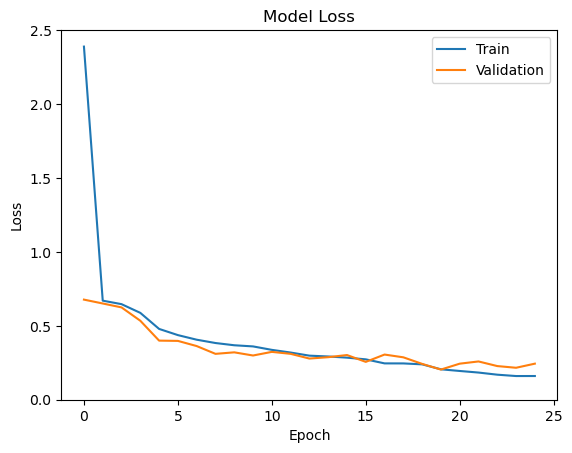

In [56]:
# Setting up the neural network architecture
model = keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1/255),
    # Hidden layers
    layers.Conv2D(8, KERNEL_SIZE, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(.3),
    # Output layer, single neuron
    layers.Dense(1, activation='sigmoid')
])

"""
All metrics are added, not sure which ones we are interested in
metrics=['accuracy', precision, 'recall', 'f1', 'AUC']
"""
model.compile(loss='binary_crossentropy', optimizer=Adam(LEARNING_RATE), metrics=['accuracy'])
# baseline ln2
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, baseline = 0.693)
results = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[callback])

print(model.summary())

# Plot the training and validation loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1, 1))
plt.xticks(np.arange(EPOCHS + 1, step=5))
plt.ylim(ymin=0)
plt.show()

In [8]:
tuner.results_summary()

In [22]:
tuner.get_best_models()[0].evaluate(test_ds)

17/17 [==============================] - 2s 72ms/step - loss: 0.2400 - accuracy: 0.9144


[0.23997417092323303, 0.9143968820571899]

In [23]:
print(type(test_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [24]:
best_model = tuner.get_best_models()[0]
y_pred = best_model.predict(test_ds)

17/17 [==============================] - 2s 81ms/step


In [30]:
import numpy as np
import tensorflow as tf

# Assuming you have a test dataset (test_ds) and a trained model (model)

best_model = tuner.get_best_models()[0]

# Convert the test dataset to a NumPy array
X_test = np.concatenate([x.numpy() for x, _ in test_ds], axis=0)
y_test = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Make predictions using the trained model
y_pred = np.argmax(best_model.predict(X_test), axis=1)

# Determine the unique class labels
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Create an empty confusion matrix
num_classes = len(unique_labels)
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Fill the confusion matrix
for true, pred in zip(y_test, y_pred):
    true_index = np.where(unique_labels == true)[0][0]
    pred_index = np.where(unique_labels == pred)[0][0]
    confusion_matrix[true_index, pred_index] += 1

print("Confusion Matrix:")
print(confusion_matrix)


17/17 [==============================] - 1s 55ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [6]:
#useful for loading the model
import tensorflow as tf

def get_model():
    model = keras.Sequential([
        keras.layers.experimental.preprocessing.Rescaling(1/255),
        # Hidden layers
        layers.Conv2D(8, KERNEL_SIZE, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        # Output layer, single neuron
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    return model
model = get_model()
# best checkpoint
checkpoint_dir = 'grid_search/random/trial_09/'

# Load the weights from the checkpoint files
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.evaluate(test_ds)

17/17 [==============================] - 2s 76ms/step - loss: 0.2400 - accuracy: 0.9144


[0.23997417092323303, 0.9143968820571899]

In [7]:
import numpy as np
import tensorflow as tf
import sklearn
#import sklearn
#from sklearn.metrics import confusion_matrix

X_test = []
y_test = []

for batch in test_ds:
    features, labels = batch
    X_test.append(features.numpy())
    y_test.append(labels.numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)


y_pred = model.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))
print(confusion_matrix)

17/17 [==============================] - 1s 59ms/step
[[247  19]
 [ 25 223]]


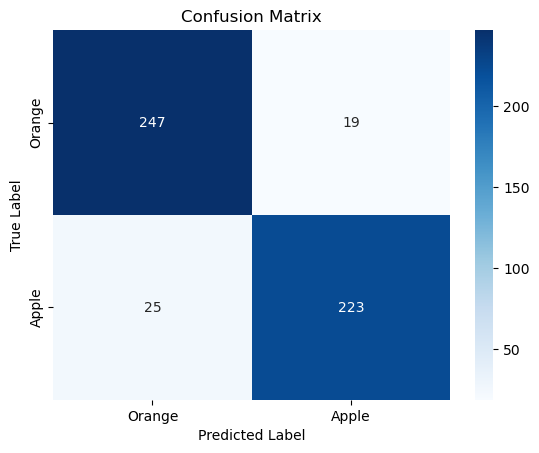

In [11]:
import seaborn as sns
cm = confusion_matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Orange", "Apple"], yticklabels=["Orange", "Apple"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()